# Classifying Risks Leveraging Poisson Regression Model

- The frequency of claim is the target variable here.
- Minimal risk rating factor that can be leveraged to classify risks into frequency bands will be a good outcome to nail down
- Make the model an inference service that can bedeployed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

## But First, Shall We Prepare the Dataset 

- Claims data includes yearly totals and breakdowns by claim type.
- Aggregate the claims data to obtain the claims frequency unique to each ID and year
- Merge result with rating factors on (ID, year).
- Assign a frequency of 0 to policies with no recorded claims.

In [91]:
rating_factors = pd.read_csv('../data/input/exp/Motor vehicle insurance data.csv', delimiter=";")
claims =  pd.read_csv('../data/input/exp/sample type claim.csv', delimiter=';')

In [92]:
claims_frequency  = (
    claims
    .groupby(['ID', 'Cost_claims_year'])
    .agg({
        'Cost_claims_by_type': 'count'})
    .rename(columns={'Cost_claims_by_type': 'claims_frequency'})
    .reset_index()
)

In [93]:
dataset = (
    pd.merge(
        left=rating_factors,
        right=claims_frequency,
        how='left',
        on=['ID', 'Cost_claims_year']
    )
)
dataset

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,claims_frequency
0,1,05/11/2015,05/11/2015,05/11/2016,15/04/1956,20/03/1976,0,4,1,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
1,1,05/11/2015,05/11/2016,05/11/2017,15/04/1956,20/03/1976,0,4,1,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
2,1,05/11/2015,05/11/2017,05/11/2018,15/04/1956,20/03/1976,0,4,2,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
3,1,05/11/2015,05/11/2018,05/11/2019,15/04/1956,20/03/1976,0,4,2,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
4,2,26/09/2017,26/09/2017,26/09/2018,15/04/1956,20/03/1976,0,4,2,2,...,0,2004,80,599,7068.00,0,P,NaN,190,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105550,53498,30/07/2018,30/07/2018,30/07/2019,25/07/1981,14/02/2007,0,1,1,1,...,0,2000,110,1997,24320.00,5,D,4.740,1480,NaN
105551,53499,16/08/2018,16/08/2018,16/08/2019,08/12/1976,29/11/2017,0,1,1,1,...,0,2013,129,1998,30861.97,5,P,4.650,1440,NaN
105552,53500,21/11/2018,21/11/2018,21/11/2019,01/04/1974,05/10/2011,0,1,1,1,...,0,1999,55,999,7800.00,5,P,3.495,830,NaN
105553,53501,21/11/2018,21/11/2018,21/11/2019,15/09/1946,02/02/1982,0,1,1,1,...,0,2004,90,1753,16610.00,5,D,4.555,1399,NaN


## Claims rate per unit exposure
- The data is structured such that each record is policy that runs for a year, as such let's calculate the claims rate per unit exposure (policy length)
- Creating matrix a using - Age, driving lenght, insurable object type (e.g van, motorcycle etc.)
    - Age banded into 3 levels of 0-35, 36-70, >70 as 0,1,2
    - Driving length banded into 2 levels of less than 5 years of experience and greater than 5 years experience as 0,1
    - Type risk has levels 1,2,3,4 representing motorbikes, van, passengers and agricultural vehicles respectively

In [94]:
rating_factors_a = (
    dataset
    .copy()[['Date_driving_licence','Date_birth','Type_risk', 'claims_frequency','Cost_claims_year',
             "Date_last_renewal", "Date_next_renewal","Seniority", "Payment", "Policies_in_force",
             "Second_driver", "R_Claims_history", "Power", "Value_vehicle", "N_claims_year","N_claims_history",
             "Lapse", "Distribution_channel"]]
             
    .fillna({'Date_driving_licence': pd.NaT,  'claims_frequency': 0})
    .assign(age_band=lambda x: pd.cut((pd.Timestamp.now() - pd.to_datetime(x['Date_birth'], dayfirst=True)).dt.days // 365, 
                                 bins=[0, 35, 70, float('inf')], 
                                 labels=[0, 1, 2], 
                                 include_lowest=True).astype(int))
    .assign(driving_length=lambda x:((pd.Timestamp.now() - pd.to_datetime(x['Date_driving_licence'], dayfirst=True)).dt.days // 365 >= 5).astype(int))
    .drop(columns=['Date_driving_licence', 'Date_birth'], axis=1)
    .assign(policy_length=lambda x: (pd.to_datetime(x['Date_next_renewal'], dayfirst=True) - pd.to_datetime(x["Date_last_renewal"], dayfirst=True)).dt.days)
)
rating_factors_a

,Type_risk,claims_frequency,Cost_claims_year,Date_last_renewal,Date_next_renewal,Seniority,Payment,Policies_in_force,Second_driver,R_Claims_history,Power,Value_vehicle,N_claims_year,N_claims_history,Lapse,Distribution_channel,age_band,driving_length,policy_length
0,1,0.0,0.0,05/11/2015,05/11/2016,4,0,1,0,0.0,80,7068.00,0,0,0,0,1,1,366
1,1,0.0,0.0,05/11/2016,05/11/2017,4,0,1,0,0.0,80,7068.00,0,0,0,0,1,1,365
2,1,0.0,0.0,05/11/2017,05/11/2018,4,0,2,0,0.0,80,7068.00,0,0,0,0,1,1,365
3,1,0.0,0.0,05/11/2018,05/11/2019,4,0,2,0,0.0,80,7068.00,0,0,0,0,1,1,365
4,1,0.0,0.0,26/09/2017,26/09/2018,4,1,2,0,0.0,80,7068.00,0,0,0,0,1,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105550,3,0.0,0.0,30/07/2018,30/07/2019,1,0,1,0,0.0,110,24320.00,0,0,0,0,1,1,365
105551,3,0.0,0.0,16/08/2018,16/08/2019,1,0,1,0,0.0,129,30861.97,0,0,0,0,1,1,365
105552,3,0.0,0.0,21/11/2018,21/11/2019,1,1,1,0,0.0,55,7800.00,0,0,0,0,1,1,365
105553,2,0.0,0.0,21/11/2018,21/11/2019,1,0,1,0,0.0,90,16610.00,0,0,0,0,2,1,365


In [95]:
rating_factors_matrix = (
    rating_factors_a
    .groupby(['age_band', 'driving_length', 'Type_risk'])
    .agg({'claims_frequency':'sum', 'Cost_claims_year':'sum'})
    .assign(claims_rate_per_unit_exposure=lambda x:(x['claims_frequency']/x['Cost_claims_year']))
    .reset_index()
    .fillna({'claims_rate_per_unit_exposure':0})
)
rating_factors_matrix

,age_band,driving_length,Type_risk,claims_frequency,Cost_claims_year,claims_rate_per_unit_exposure
0,0,1,1,27.0,51431.88,0.000525
1,0,1,2,24.0,49850.71,0.000481
2,0,1,3,494.0,1423064.94,0.000347
3,0,1,4,0.0,0.00,0.000000
4,1,1,1,209.0,224939.07,0.000929
5,1,1,2,821.0,1917170.64,0.000428
6,1,1,3,5113.0,11103766.59,0.000460
7,1,1,4,0.0,192.67,0.000000
8,2,1,1,16.0,32685.29,0.000490
9,2,1,2,142.0,230731.97,0.000615


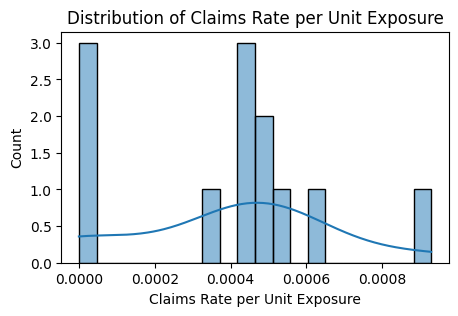

In [96]:
plt.figure(figsize=(5, 3))
sns.histplot(data=rating_factors_matrix, x='claims_rate_per_unit_exposure', bins=20, kde=True)
plt.title('Distribution of Claims Rate per Unit Exposure')
plt.xlabel('Claims Rate per Unit Exposure')
plt.ylabel('Count')
plt.show()


## Poisson Model - Shall we fit one?

In [97]:
train_dev, test = train_test_split(rating_factors_a, test_size=0.05, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.1, random_state=42)

print(f"Train set size: {len(train)}")
print(f"Dev set size: {len(dev)}")
print(f"Test set size: {len(test)}")
print(f"Total: {len(train) + len(dev) + len(test)}")

Train set size: 90249
Dev set size: 10028
Test set size: 5278
Total: 105555


In [98]:
X = train_dev[['Type_risk', 'age_band', 'policy_length', 'Seniority', "Second_driver",
               "R_Claims_history", "N_claims_year", "N_claims_history", ]]
y = train_dev[['claims_frequency']]

In [99]:
X

,Type_risk,age_band,policy_length,Seniority,Second_driver,R_Claims_history,N_claims_year,N_claims_history
12282,3,2,365,3,0,0.00,0,2
32446,3,2,365,2,0,0.00,0,1
59411,3,1,365,2,0,1.00,1,1
885,2,2,366,15,0,0.00,0,0
28961,3,1,366,3,0,0.00,0,1
...,...,...,...,...,...,...,...,...
54886,3,1,365,4,0,0.00,0,0
76820,3,1,365,4,0,0.33,0,1
103694,3,1,365,4,0,0.42,0,2
860,3,2,366,6,0,0.50,2,6


In [100]:
fit = sm.GLM(
    y,
    X, #[['intercept', 'Type_risk', 'age_band']],
    # offset=np.log(X['policy_length']),
    family=sm.families.NegativeBinomial()
)
model = fit.fit()
print(model.summary())

/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       claims_frequency   No. Observations:               100277
Model:                            GLM   Df Residuals:                   100269
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21646.
Date:                Tue, 08 Jul 2025   Deviance:                       27542.
Time:                        22:09:05   Pearson chi2:                 8.02e+04
No. Iterations:                    29   Pseudo R-squ. (CS):            0.08156
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Type_risk            0.1858      0.026  

In [105]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson

X = sm.add_constant(X)
zero_model =  ZeroInflatedPoisson(endog=y, exog=X).fit()
print(zero_model.summary())

/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/discrete/count_model.py:629: RuntimeWarning: overflow encountered in exp
  coeff = (1 + w[zero_idx] * (np.exp(mu[zero_idx]) - 1))
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/discrete/count_model.py:637: RuntimeWarning: overflow encountered in exp
  w[zero_idx] * mu[zero_idx] * np.exp(mu[zero_idx]) /
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/sit

         Current function value: 0.199982
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        claims_frequency   No. Observations:               100277
Model:             ZeroInflatedPoisson   Df Residuals:                   100268
Method:                            MLE   Df Model:                            8
Date:                 Tue, 08 Jul 2025   Pseudo R-squ.:                  0.1695
Time:                         22:18:39   Log-Likelihood:                -20054.
converged:                       False   LL-Null:                       -24145.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
inflate_const        1.0332        nan        nan       

In [107]:
from statsmodels.discrete.discrete_model import GeneralizedPoisson

X = sm.add_constant(X)
general_model =  GeneralizedPoisson(endog = y , exog = X, p=2).fit(method='nm')
print(general_model.summary())

/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                    GeneralizedPoisson Regression Results                     
Dep. Variable:       claims_frequency   No. Observations:               100277
Model:             GeneralizedPoisson   Df Residuals:                   100268
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                  0.6624
Time:                        22:20:04   Log-Likelihood:                -31256.
converged:                      False   LL-Null:                       -92591.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -247.4376     28.061     -8.818      0.000    -302.437    -192.438
Type_risk            0.2324      0.057      4.062      0.000       0.120       0.345
age_band            -0.1561 

/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/olumide/Library/CloudStorage/OneDrive-Personal/Documents/Research/Project 1/underwriting assessor/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
